## Introduction

This short notebook compares the accuracy of four classification models over a numeric set of data:
- Decission Trees
- Random Forest
- Support Vector Machine
- K Nearest Neighbors

The data set used is a cleaned up version of cardio_train.csv available at 
https://www.kaggle.com/sulianova/cardiovascular-disease-dataset
where a number of explicative features are used to predict the presence ("1") or absence ("0") of a cardiovascular disease (CARDIO_DISEASE).

An insightful graphical representation of the decision tree is also included.

Enjoy reading!


## Data analysis and clean up

I have done a bit of pre-processing with Excel before uploading the csv file into colab. Excel is still pretty convenient for correcting wrong data manually, as shown in the AP_HIGH shadowed column below where the minus sign has been removed.

Also, there were some outliers (mainly in the AP_HIGH and AP_LOW columns) and I have removed them.

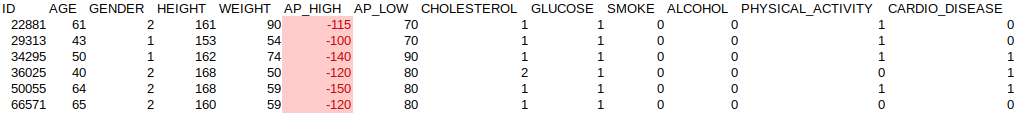

In [1]:
# Start importing the required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Upload data file into dataframe df
df = pd.read_csv("../input/cardio-data-dv13032020/cardiovascular_diseases_dv3.csv", sep=';')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68783 entries, 0 to 68782
Data columns (total 12 columns):
AGE                  68783 non-null int64
GENDER               68783 non-null int64
HEIGHT               68783 non-null int64
WEIGHT               68783 non-null int64
AP_HIGH              68783 non-null int64
AP_LOW               68783 non-null int64
CHOLESTEROL          68783 non-null int64
GLUCOSE              68783 non-null int64
SMOKE                68783 non-null int64
ALCOHOL              68783 non-null int64
PHYSICAL_ACTIVITY    68783 non-null int64
CARDIO_DISEASE       68783 non-null int64
dtypes: int64(12)
memory usage: 6.3 MB


,AGE,GENDER,HEIGHT,WEIGHT,AP_HIGH,AP_LOW,CHOLESTEROL,GLUCOSE,SMOKE,ALCOHOL,PHYSICAL_ACTIVITY,CARDIO_DISEASE
0,50,2,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,52,1,165,64,130,70,3,1,0,0,0,1
3,48,2,169,82,150,100,1,1,0,0,1,1
4,48,1,156,56,100,60,1,1,0,0,0,0


In [3]:
print(format(df.duplicated().sum())) # 3820 duplicates???

3820


In [4]:
# Explore duplicates
duplicated = df[df.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['AGE', 'GENDER', 'HEIGHT'], ascending= False) 
# I sorted the values to see duplication clearly

duplicated.head(6) # Show 3 duplicate pairs

,AGE,GENDER,HEIGHT,WEIGHT,AP_HIGH,AP_LOW,CHOLESTEROL,GLUCOSE,SMOKE,ALCOHOL,PHYSICAL_ACTIVITY,CARDIO_DISEASE
58718,65,2,174,70,120,80,1,1,0,0,1,1
66083,65,2,174,70,120,80,1,1,0,0,1,1
47549,65,1,168,64,120,80,1,1,0,0,0,1
68150,65,1,168,64,120,80,1,1,0,0,0,1
37842,65,1,163,63,120,80,1,1,0,0,0,1
43333,65,1,163,63,120,80,1,1,0,0,0,1


In [5]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(format(df.duplicated().sum())) # now 0 duplicates???

0


In [6]:
df.describe() # There are no negative values, nore ridiculous out of scale values

,AGE,GENDER,HEIGHT,WEIGHT,AP_HIGH,AP_LOW,CHOLESTEROL,GLUCOSE,SMOKE,ALCOHOL,PHYSICAL_ACTIVITY,CARDIO_DISEASE
count,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000,64963.000000
mean,53.353155,1.356511,164.347259,74.497252,126.979989,81.480766,1.384080,1.237905,0.092714,0.056663,0.797115,0.508797
std,6.811546,0.478972,8.330184,14.552793,17.116092,9.904148,0.691197,0.584059,0.290034,0.231199,0.402150,0.499926
min,30.000000,1.000000,55.000000,11.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,59.000000,2.000000,170.000000,82.500000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


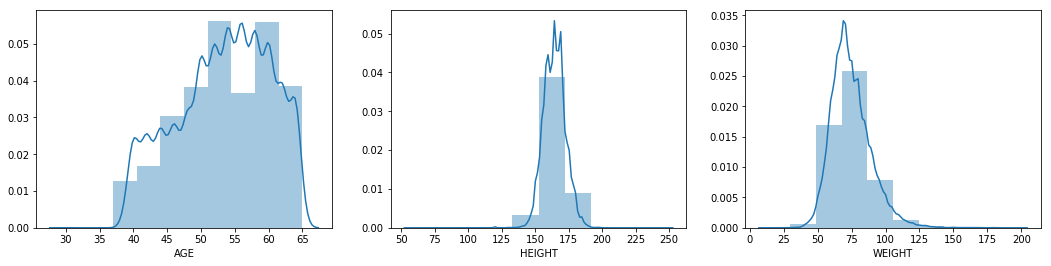

In [7]:
# Distributions of age, height and weight variables
fig, axes = plt.subplots(1,3, figsize=(18,4))
sns.distplot(df.AGE, bins=10, kde=True, ax=axes[0])
sns.distplot(df.HEIGHT, bins=10, kde=True, ax=axes[1])
sns.distplot(df.WEIGHT, bins=10, kde=True, ax=axes[2])

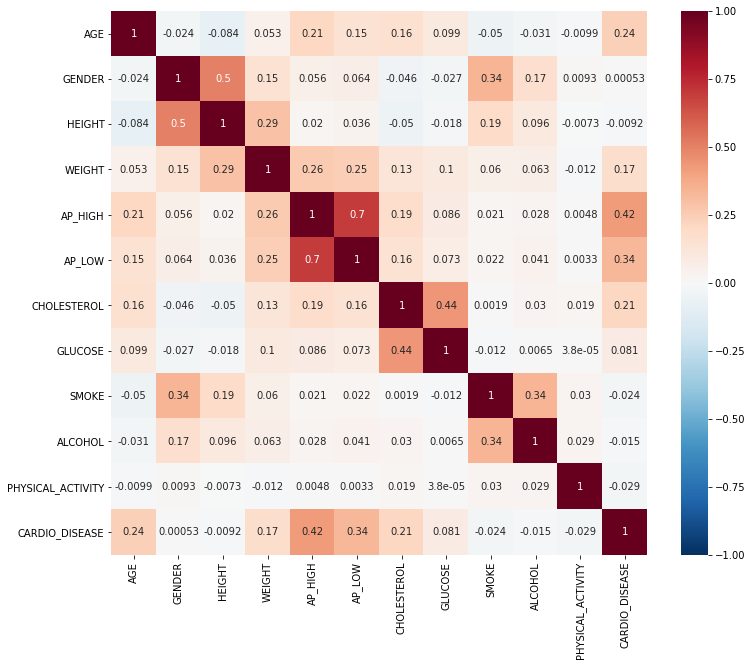

In [8]:
correlation = df.corr()

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

The most influential variables in having CARDIO_DISEASE are AGE, WEIGHT, CHOLESTEROL and primarily AP_HIGH and AP_LOW.

## Preparation of data for training models
The data set is first split into X (features) and y (target variable) components, and then randomly into train and test sub sets. 

In [9]:
# Import train_test_split and divide data into X and y components
from sklearn.model_selection import train_test_split

y = df['CARDIO_DISEASE']
X = df.drop(['CARDIO_DISEASE'], axis=1, inplace=False)
X.head()

,AGE,GENDER,HEIGHT,WEIGHT,AP_HIGH,AP_LOW,CHOLESTEROL,GLUCOSE,SMOKE,ALCOHOL,PHYSICAL_ACTIVITY
0,50,2,168,62,110,80,1,1,0,0,1
1,55,1,156,85,140,90,3,1,0,0,1
2,52,1,165,64,130,70,3,1,0,0,0
3,48,2,169,82,150,100,1,1,0,0,1
4,48,1,156,56,100,60,1,1,0,0,0


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,                                
                                                    test_size = 0.25, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 48722 samples.
Testing set has 16241 samples.


## Decission Tree predictor

In [11]:
# Import DecissionTree classification model from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

DT_predictor = DecisionTreeClassifier(max_depth=3, min_samples_split=50, min_samples_leaf=50, random_state=13)
DT_predictor.fit(X_train, y_train)
y_predicted = DT_predictor.predict(X_test)
y_predicted

array([0, 0, 0, ..., 1, 1, 1])

In [12]:
# Evaluate the model
print("------------------------------------------------------") 
print("Confussion Matrix")
print("------------------------------------------------------")
print(confusion_matrix(y_test,y_predicted))
print("------------------------------------------------------")
print("Classification Report")
print("------------------------------------------------------")
print(classification_report(y_test,y_predicted))
print("------------------------------------------------------")
DT_accuracy = round(accuracy_score(y_test, y_predicted), 2)
print("Overall accuracy score: " + str(DT_accuracy))
print("------------------------------------------------------")

------------------------------------------------------
Confussion Matrix
------------------------------------------------------
[[6102 1941]
 [2581 5617]]
------------------------------------------------------
Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      8043
           1       0.74      0.69      0.71      8198

    accuracy                           0.72     16241
   macro avg       0.72      0.72      0.72     16241
weighted avg       0.72      0.72      0.72     16241

------------------------------------------------------
Overall accuracy score: 0.72
------------------------------------------------------


In [13]:
# Install pydotplus package into the kernel
!pip install pydotplus

     |████████████████████████████████| 278 kB 418 kB/s 
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=c3c3f118b63c09f9e39ba1a46cc8932333cae6670f8e6c8b5c03ffa7ec7f5096
  Stored in directory: /root/.cache/pip/wheels/1f/5c/ba/f931f74fcac8f48b18ae597279203b1c1f92fc76249c2b6f66
Successfully built pydotplus


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


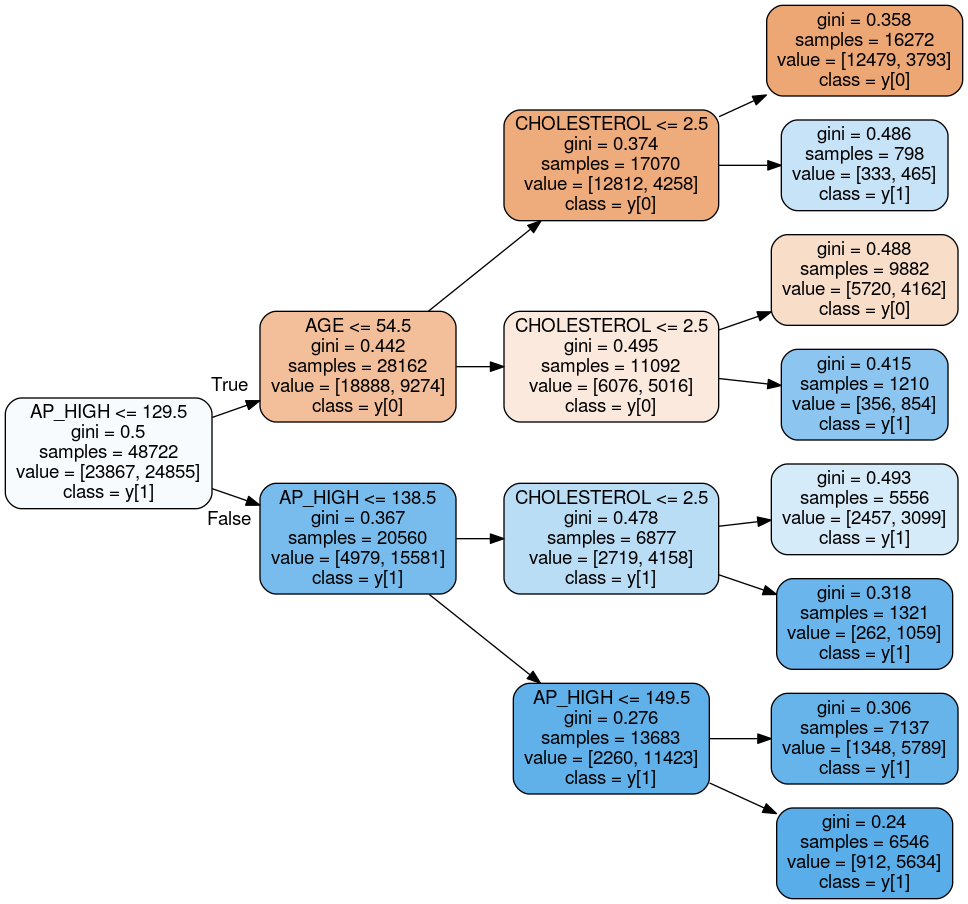

In [14]:
# Plot the Decission Tree model created with X_train, y_train
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus as pydot

dot_data = StringIO()

export_graphviz(DT_predictor, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names=X.columns,
                class_names=True,
                rotate=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Random Forest predictor

In [15]:
# Import Random Forest classification model from sklearn
from sklearn.ensemble import RandomForestClassifier

RF_predictor = RandomForestClassifier(n_estimators=50, random_state=17)
RF_predictor.fit(X_train, y_train)
y_predicted = RF_predictor.predict(X_test)
y_predicted

array([0, 0, 1, ..., 1, 1, 1])

In [16]:
# Evaluate the model
print("------------------------------------------------------") 
print("Confussion Matrix")
print("------------------------------------------------------")
print(confusion_matrix(y_test,y_predicted))
print("------------------------------------------------------")
print("Classification Report")
print("------------------------------------------------------")
print(classification_report(y_test,y_predicted))
print("------------------------------------------------------")
RF_accuracy = round(accuracy_score(y_test, y_predicted), 2)
print("Overall accuracy score: " + str(RF_accuracy))
print("------------------------------------------------------")

------------------------------------------------------
Confussion Matrix
------------------------------------------------------
[[5490 2553]
 [2484 5714]]
------------------------------------------------------
Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      8043
           1       0.69      0.70      0.69      8198

    accuracy                           0.69     16241
   macro avg       0.69      0.69      0.69     16241
weighted avg       0.69      0.69      0.69     16241

------------------------------------------------------
Overall accuracy score: 0.69
------------------------------------------------------


## Support Vector Machine (SVM) predictor

In [17]:
# Feature Scaling, required by SVM and KNN algorithms
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Import SVM classification model from sklearn
from sklearn.svm import SVC

SV_classifier = SVC(kernel='linear')
SV_classifier.fit(X_train, y_train)
y_predicted = SV_classifier.predict(X_test)
y_predicted

array([0, 0, 0, ..., 1, 1, 1])

In [18]:
# Evaluate the model
print("------------------------------------------------------") 
print("Confussion Matrix")
print("------------------------------------------------------")
print(confusion_matrix(y_test,y_predicted))
print("------------------------------------------------------")
print("Classification Report")
print("------------------------------------------------------")
print(classification_report(y_test,y_predicted))
print("------------------------------------------------------")
SV_accuracy = round(accuracy_score(y_test, y_predicted), 2)
print("Overall accuracy score: " + str(SV_accuracy))
print("------------------------------------------------------")

------------------------------------------------------
Confussion Matrix
------------------------------------------------------
[[6334 1709]
 [2774 5424]]
------------------------------------------------------
Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      8043
           1       0.76      0.66      0.71      8198

    accuracy                           0.72     16241
   macro avg       0.73      0.72      0.72     16241
weighted avg       0.73      0.72      0.72     16241

------------------------------------------------------
Overall accuracy score: 0.72
------------------------------------------------------


## K Nearest Neighbors predictor

In [19]:
# Feature Scaling also needed, but already performed

In [20]:
# Import KNN classification model from sklearn
from sklearn.neighbors import KNeighborsClassifier

KNN_classifier = KNeighborsClassifier(n_neighbors=25)
KNN_classifier.fit(X_train, y_train)
y_predicted = KNN_classifier.predict(X_test)
y_predicted

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
# Evaluate the model
print("------------------------------------------------------") 
print("Confussion Matrix")
print("------------------------------------------------------")
print(confusion_matrix(y_test,y_predicted))
print("------------------------------------------------------")
print("Classification Report")
print("------------------------------------------------------")
print(classification_report(y_test,y_predicted))
print("------------------------------------------------------")
KNN_accuracy = round(accuracy_score(y_test, y_predicted), 2)
print("Overall accuracy score: " + str(KNN_accuracy))
print("------------------------------------------------------")

------------------------------------------------------
Confussion Matrix
------------------------------------------------------
[[5979 2064]
 [2484 5714]]
------------------------------------------------------
Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      8043
           1       0.73      0.70      0.72      8198

    accuracy                           0.72     16241
   macro avg       0.72      0.72      0.72     16241
weighted avg       0.72      0.72      0.72     16241

------------------------------------------------------
Overall accuracy score: 0.72
------------------------------------------------------


In [22]:
# Compare accuracy of the four classification models
compare_scores = {'Decission Tree': DT_accuracy, 'Random Forest': RF_accuracy, 'Support Vector Machine (SVM)': SV_accuracy, 'K Nearest Neighbors (KNN)': KNN_accuracy}
compare_scores

{'Decission Tree': 0.72,
 'Random Forest': 0.69,
 'Support Vector Machine (SVM)': 0.72,
 'K Nearest Neighbors (KNN)': 0.72}

End of notebook